# CK+ dataset : reconnaissance d'émotion

Je vais appliquer ici une approche de classification par deep learning à base de convolution neural networks à un dataset d'images obtenues sur kaggle à l'adresse https://www.kaggle.com/datasets/davilsena/ckdataset qui associent à chaque image une émotion.

Les informations données sur le site sont : 

*Contains adaptaded data up to 920 images from 920 original Cohn-Kanade Dataset (CK+) dataset.*

*Data is already reshaped to 48x48 pixels, in grayscale format and facecropped using haarcascade_frontalface_default.*

*Noisy (based on room light/hair format/skin colour) images were adapted to be clearly identified using Haar classifier.*

*Columns from file are defined as emotion/pixels/Usage*

*Emotions are defined as determined index below:*

    0 : Anger (45 samples)
    1 : Disgust (59 samples)
    2 : Fear (25 samples)
    3 : Happiness (69 samples)
    4 : Sadness (28 samples)
    5 : Surprise (83 samples)
    6 : Neutral (593 samples)
    7 : Contempt (18 samples)

*Pixels contains 2304 pixels (48x48) each row.*


# Import et lecture des données

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Conv2DTranspose, Reshape, Dense, Activation, Flatten, \
                                    Dropout, Convolution2D, MaxPooling2D, Input, Resizing, Concatenate
import time


np.random.seed(0)

In [2]:
data=pd.read_csv('ckextended.csv')

In [3]:
data.head()


,emotion,pixels,Usage
0,6,36 39 35 25 19 11 8 7 3 13 15 9 21 57 75 90 10...,Training
1,6,88 74 19 4 5 5 3 12 8 21 15 21 15 18 24 29 32 ...,Training
2,6,9 2 4 7 1 1 1 0 7 29 49 76 115 141 156 169 177...,Training
3,6,104 106 108 104 95 50 60 61 58 83 126 133 139 ...,Training
4,6,68 72 67 67 6 2 1 1 1 1 1 14 24 24 38 65 79 94...,Training


In [4]:
data.dtypes

emotion     int64
pixels     object
Usage      object
dtype: object

In [5]:
print(data.shape)
print(len(data.pixels[0].split()) , 48*48)


(920, 3)
2304 2304


On a 920 images de taille 48 x 48 représentées par le champ 'pixels' sous forme de chaines de caractères de longueur 2304, valant entre 0 et 255.
On a également une classe emotion qui sera notre cible, et une classe usage que je n'utiliserais pas.

## Aperçu des images

In [6]:
def df2im (df, i) :
    """Renvoit l'image correspondant à la ligne 'i' du dataframe 'df' sous forme d'un array numpy
    """
    foo=df.loc[i, 'pixels']
    im=np.reshape(foo.split(), [48,48]).astype('int')
    return im

In [7]:
emotion_list=['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral', 'Contempt']

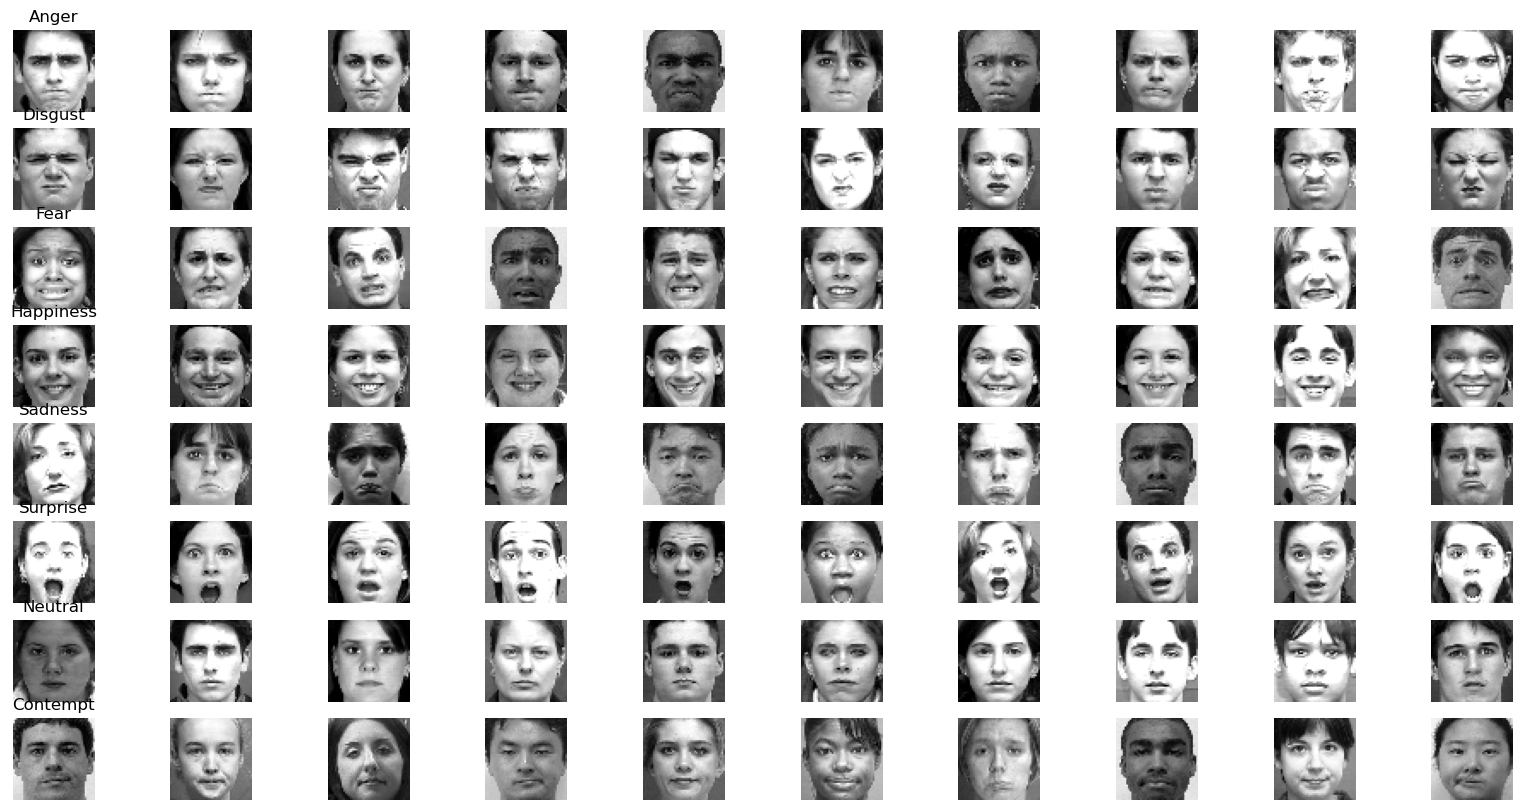

In [8]:
plt.figure(figsize=(20,10))
for i in range(8) :
    df_emo=data[data.emotion == i].reset_index(drop=True)
    for j in range(10):
        plt.subplot(8,10, i*10+j+1)
        plt.imshow( df2im(df_emo,j), cmap='gray' )
        plt.axis('off')
        if j == 0 :
            plt.title(emotion_list[i])
plt.show()

On peut voir que ce sont des personnes à qui on a demandé de surjouer des émotions. On distingue assez bien les catégories, donc le dataset a l'air utilisable, bien que les classes autres que 'neutral' aient peu de lignes. 

# Première approche

In [9]:
#On copie la fonction montrant l'historique des résultats
def affiche(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## Définition des ensembles d'entrainement et test

On commence par regarder les résultats en adaptant directement la méthode par CNN appliquées à la reconnaissance de caractères.

In [10]:
x_temp=data.pixels
x=np.zeros((920, 2304))
for i in range(920) :
    x[i,:]=x_temp[i].split()
x/=255

x=np.reshape(x, (920, 48,48, 1) )
    
y=data.emotion


In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

#On convertit les valeurs de sortie de 0 à 7 en vecteurs
Y_train = tf.keras.utils.to_categorical(y_train, 8)
Y_test = tf.keras.utils.to_categorical(y_test, 8)

x_train.shape, x_test.shape, y_train.shape, Y_train.shape, Y_test.shape

((828, 48, 48, 1), (92, 48, 48, 1), (828,), (828, 8), (92, 8))

## Définition du modèle

In [12]:
inputs = Input(shape=(48,48,1)) 
tens = Convolution2D(32, kernel_size = (3, 3), activation='relu' )(inputs) 
tens = Convolution2D(64, kernel_size = (3, 3), activation='relu' )(tens) 
tens = MaxPooling2D((3, 3))(tens) 
tens = Flatten()(tens) 
tens = Dense(256, activation='relu')(tens) 
tens = Dropout(0.5)(tens) 
# outputs= Dense(8, activation='softmax')(tens) 
outputs= Dense(8)(tens) 
model = Model(inputs, outputs) 
model.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 256)               3211520   
                                                             

2023-03-02 10:03:02.783756: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-02 10:03:02.783773: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-02 10:03:02.783785: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (py4bd-06): /proc/driver/nvidia/version does not exist
2023-03-02 10:03:02.784133: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Entrainement

In [13]:
lr= 0.13
batch_size=40
epochs=8
sgd1= tf.keras.optimizers.SGD(learning_rate=lr,momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=sgd1, metrics=['accuracy'])
tps1 = time.perf_counter()
history =model.fit(x_train, Y_train, batch_size=batch_size, epochs=epochs,
verbose=1,validation_data=(x_test, Y_test))
tps2 = time.perf_counter()

print('lr=',lr,'batch_size=',batch_size, 'epochs=',epochs)
print('Temps d apprentissage',tps2 - tps1)

Epoch 1/8
21/21 [==============================] - 2s 79ms/step - loss: 4.1539 - accuracy: 0.0229 - val_loss: 3.5625 - val_accuracy: 0.0217
Epoch 2/8
21/21 [==============================] - 1s 68ms/step - loss: 3.8034 - accuracy: 0.0193 - val_loss: 3.5120 - val_accuracy: 0.0217
Epoch 3/8
21/21 [==============================] - 1s 67ms/step - loss: 4.0726 - accuracy: 0.0193 - val_loss: 3.5039 - val_accuracy: 0.0217
Epoch 4/8
21/21 [==============================] - 2s 74ms/step - loss: 5.0826 - accuracy: 0.0193 - val_loss: 3.5039 - val_accuracy: 0.0217
Epoch 5/8
21/21 [==============================] - 1s 67ms/step - loss: 5.9199 - accuracy: 0.0193 - val_loss: 3.5039 - val_accuracy: 0.0217
Epoch 6/8
21/21 [==============================] - 1s 66ms/step - loss: 6.1132 - accuracy: 0.0193 - val_loss: 3.5039 - val_accuracy: 0.0217
Epoch 7/8
21/21 [==============================] - 2s 76ms/step - loss: 7.2621 - accuracy: 0.0193 - val_loss: 3.5039 - val_accuracy: 0.0217
Epoch 8/8
21/21 [===

## Analyse des résultats

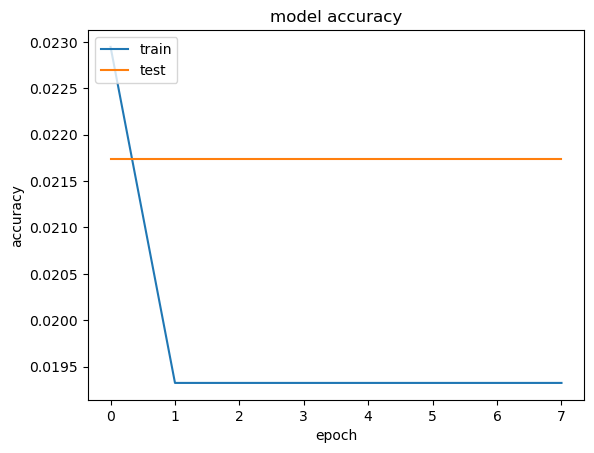

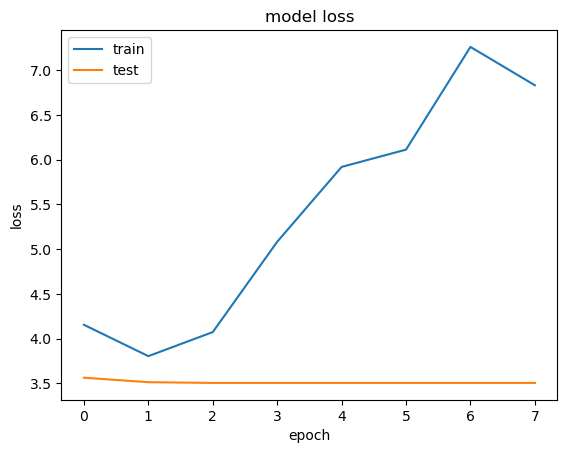

In [14]:
affiche(history)

In [15]:
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=-1)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))

3/3 [==============================] - 0s 9ms/step
Confusion Matrix
[[ 0  0  0  0  0  0  0  6]
 [ 0  0  0  0  0  0  0  3]
 [ 0  0  0  0  0  0  0  6]
 [ 0  0  0  0  0  0  0  5]
 [ 0  0  0  0  0  0  0  3]
 [ 0  0  0  0  0  0  0  6]
 [ 0  0  0  0  0  0  0 61]
 [ 0  0  0  0  0  0  0  2]]


L'approche actuel ne marche pas : toutes les images sont classées dans la même catégorie ('neutral', soit la plus nombreuse, mais j'ai eu une fois tous les résultats dans une autre colonne sur 5 ou 6 essais).
(NB : Selon les rééxécutions du programme, il s'agit parfois d'une autre classe qui reçoit toutes les prédictions, mais 'neutral' est beaucoup plus fréquente que les autres donc tous les commentaires sont écrits avec elle.)

On a également une convergence quasi-immédiate sans évolution par la suite, et un overfitting marqué.

## Observation plus poussée des images

La méthode actuelle n'identifie pas les features voulues. 
Visuellement, on s'attend à ce que la forme des yeux et de la bouche soient des éléments importants pour la classification. 
Et identifier des traits prenant des directions différentes selon la classe devrait être ce que les convolutions détectent bien, donc l'approche suivie n'a pas l'air aberrante. 

On va tracer de quoi a l'air une image après convolution pour voir.

In [16]:
#Version basique de la convolution en supposant la 2e image 3x3 , et les 2 images carrées :
def conv2d(im1, ker) :
    N=im1.shape[0]
    Nk=ker.shape[0]
    im_out=np.zeros((N,N))
    for i in range(1,N-1) :
        for j in range(1,N-1) :
            for di in range(3) :
                for dj in range(3) :
                    im_out[i,j]+=im1[i+di-1,j+dj-1]*ker[Nk-di-1,Nk-dj-1]
    im_out=im_out[1:N-1, 1:N-1]
    return im_out


In [17]:
#Génération des images
im_in=x_train[0].reshape(48,48)

kernel_v=np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
im_v=conv2d(im_in, kernel_v)

kernel_h=np.array([[1,0,-1],[1,0,-1],[1,0,-1]])
im_h=conv2d(im_in, kernel_h)

(-0.5, 45.5, 45.5, -0.5)

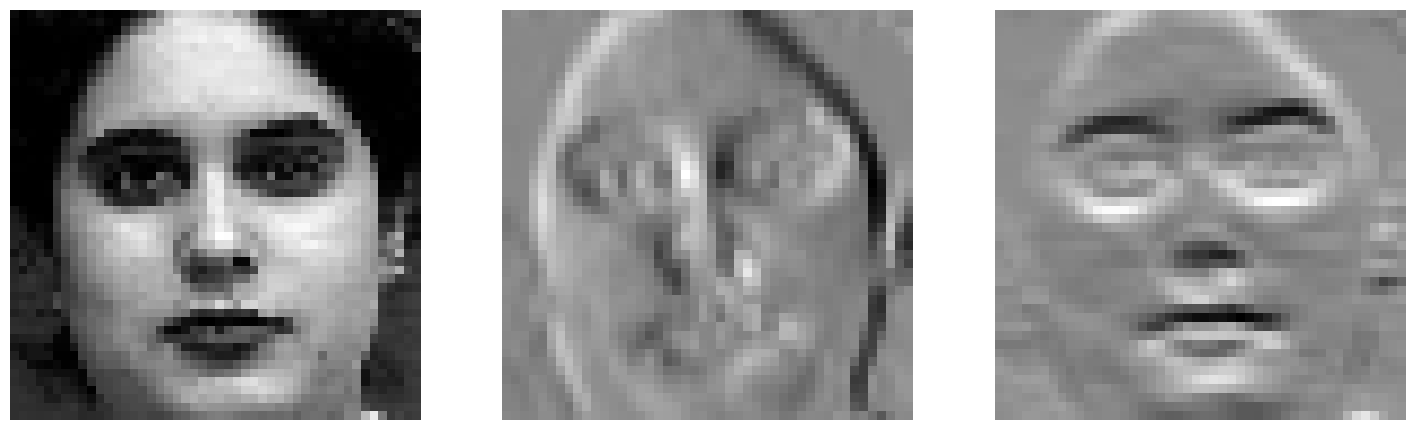

In [18]:
#Tracé des images
plt.figure(figsize=(18,6))

plt.subplot(131)
plt.imshow(im_in, cmap='gray' )
plt.axis('off')
plt.subplot(132)
plt.imshow(im_h, cmap='gray' )
plt.axis('off')
plt.subplot(133)
plt.imshow(im_v, cmap='gray' )
plt.axis('off')

L'image de droite, avec un gradient vertical, fait bien ressortir la forme de la bouche et des yeux/sourcils, donc ces zones devraient en effet apporter de l'information. 

Une approche pourrait être de mettre à zero les points loin des yeux et de la bouche, mais je m'attends à ce que négliger ces zones peu significatives soit déjà fait par le réseau de neurones.

Une autre chose que l'on avait corrigé en TP était de s'assurer que les images sont comparables en moyenne et écart-type. Il existe une layer BatchNormalization() qui fait cela. 

On a cependant des distributions de valeurs assez proches, vers 0.5 de moyenne et 0.25 d'écart-type :

In [19]:
mean_vec=np.zeros(920)
std_vec=np.zeros(920)
for i in range(920) : 
    mean_vec[i]=x[i,:,:,0].mean()
    std_vec[i]=x[i,:,:,0].std()

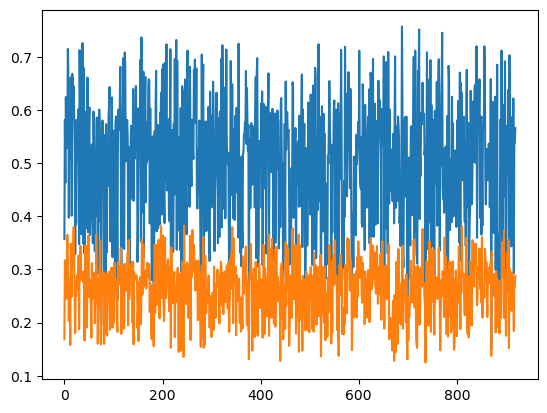

In [20]:
plt.plot(mean_vec)
plt.plot(std_vec)

# Tentatives de résolution

## Suppression de la catégorie 'Neutral'

Toutes les prédictions sont dans la catégorie 'neutral' qui représente la moitié des données.
On va donc voir si cette classe a juste un poids trop élevé, et si on a des résultats corrects sans elle.

In [21]:
xmod=x[y != 6]
ymod=y[y != 6]
xmod.shape, ymod.shape

((327, 48, 48, 1), (327,))

In [22]:
xmod_train, xmod_test, ymod_train, ymod_test = train_test_split(xmod, ymod, test_size=0.1)

Ymod_train = tf.keras.utils.to_categorical(ymod_train, 8)
Ymod_test = tf.keras.utils.to_categorical(ymod_test, 8)

xmod_train.shape, xmod_test.shape, ymod_train.shape, Ymod_train.shape, Ymod_test.shape

((294, 48, 48, 1), (33, 48, 48, 1), (294,), (294, 8), (33, 8))

In [23]:
inputs = Input(shape=(48,48,1)) 
tens = Convolution2D(32, kernel_size = (3, 3), activation='relu' )(inputs) 
tens = Convolution2D(64, kernel_size = (3, 3), activation='relu' )(tens) 
tens = MaxPooling2D((3, 3))(tens) 
tens = Flatten()(tens) 
tens = Dense(256, activation='relu')(tens) 
tens = Dropout(0.5)(tens) 
outputs= Dense(8, activation='softmax')(tens) 
model = Model(inputs, outputs) 
# model.summary() 

In [24]:
lr= 0.8
moment=0.8
batch_size=20
epochs=10
sgd1= tf.keras.optimizers.SGD(learning_rate=lr,momentum=moment)
model.compile(loss='categorical_crossentropy', optimizer=sgd1, metrics=['accuracy'])
tps1 = time.perf_counter()
history =model.fit(xmod_train, Ymod_train, batch_size=batch_size, epochs=epochs, 
                   verbose=0,validation_data=(xmod_test, Ymod_test))
tps2 = time.perf_counter()

# print('lr=',lr,'batch_size=',batch_size, 'epochs=',epochs)
# print('Temps d apprentissage',tps2 - tps1)

In [25]:
ymod_pred = model.predict(xmod_test)
ymod_pred = ymod_pred.argmax(axis=-1)
print('Confusion Matrix')
print(confusion_matrix(ymod_test, ymod_pred))

2/2 [==============================] - 0s 3ms/step
Confusion Matrix
[[ 0  4  0  0  0  0]
 [ 0  3  0  0  0  0]
 [ 0  3  0  0  0  0]
 [ 0 13  0  0  0  0]
 [ 0  1  0  0  0  0]
 [ 0  9  0  0  0  0]]


On peut voir que même avec des catégories en nombre comparable, toutes les prédictions sont dans une même nouvelle classe.

## Augmentation de la taille du réseau

Une autre solution pourrait être de multiplier par 2 ou 4 tous les nombres de neurones, si jamais le problème était que l'analyse était trop légère pour la complexité du problème. 

Mais j'ai coupé cette partie qui prenait du temps sans améliorer les résultats. On avait toujours une seule classe

In [26]:
# inputs = Input(shape=(48,48,1)) 
# tens = Convolution2D(64, kernel_size = (3, 3), activation='relu' )(inputs) 
# tens = Convolution2D(128, kernel_size = (3, 3), activation='relu' )(tens) 
# tens = MaxPooling2D((3, 3))(tens) 
# tens = Flatten()(tens) 
# tens = Dense(512, activation='relu')(tens) 
# tens = Dropout(0.5)(tens) 
# outputs= Dense(8, activation='softmax')(tens) 
# model = Model(inputs, outputs) 
# model.summary() 

In [27]:
# lr= 0.13
# batch_size=20
# epochs=8
# sgd1= tf.keras.optimizers.SGD(learning_rate=lr,momentum=0.6)
# model.compile(loss='categorical_crossentropy', optimizer=sgd1, metrics=['accuracy'])
# tps1 = time.perf_counter()
# history =model.fit(x_train, Y_train, batch_size=batch_size, epochs=epochs,
# verbose=1,validation_data=(x_test, Y_test))
# tps2 = time.perf_counter()

# print('lr=',lr,'batch_size=',batch_size, 'epochs=',epochs)
# print('Temps d apprentissage',tps2 - tps1)

In [28]:
# y_pred = model.predict(x_test)
# y_pred = y_pred.argmax(axis=-1)
# print('Confusion Matrix')
# print(confusion_matrix(y_test, y_pred))

## Changements dans l'optimisation

Les forums en ligne utilisaient souvent un 'learning rate' très faible pour la 'computer vision', de l'ordre de 0.01 ou 0.001. 
J'ai lancé plusieurs fois les calculs avec de plus faibles learning rate, et j'ai occasionnellement eu des valeurs sur une deuxième colonne, mais pas de façon assez reproductible pour l'afficher ici. 

Cela a cependant montré que c'était sur les termes de l'optimisation qu'il fallait jouer. 
Après coup, le fait que l'on avait généralement une convergence quasi immédiate avec la première méthode aurait dû être un élément indiquant qu'il fallait un learning rate plus faible. J'ai aussi utilisé l'optimiseur 'adam' plutôt que 'sgd', qui est censé être meilleur, en jouant uniquement sur son learning rate.


In [29]:
inputs = Input(shape=(48,48,1)) 
tens = Convolution2D(32, kernel_size = (3, 3), activation='relu' )(inputs) 
tens = Convolution2D(64, kernel_size = (3, 3), activation='relu' )(tens) 
tens = MaxPooling2D((3, 3))(tens) 
tens = Flatten()(tens) 
tens = Dense(256, activation='relu')(tens) 
tens = Dropout(0.5)(tens) 
outputs= Dense(8, activation='softmax')(tens) 
model = Model(inputs, outputs) 
# model.summary() 

In [30]:
batch_size=20
epochs=20
early=tf.keras.callbacks.EarlyStopping(patience=2)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3,
                                                             decay_steps=10000,decay_rate=0.9)

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-4), 
#               metrics=['accuracy'],
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr_schedule), 
              metrics=['accuracy'])
#               callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])
              #              )

tps1 = time.perf_counter()
history =model.fit(x_train, Y_train, batch_size=batch_size, epochs=epochs,
                   verbose=1,validation_data=(x_test, Y_test), callbacks=[early])
tps2 = time.perf_counter()



print('lr=',lr,'batch_size=',batch_size, 'epochs=',epochs)
print('Temps d apprentissage',tps2 - tps1)

Epoch 1/20
42/42 [==============================] - 3s 54ms/step - loss: 1.3860 - accuracy: 0.6256 - val_loss: 1.1965 - val_accuracy: 0.6630
Epoch 2/20
42/42 [==============================] - 2s 50ms/step - loss: 0.9614 - accuracy: 0.7077 - val_loss: 0.8501 - val_accuracy: 0.7500
Epoch 3/20
42/42 [==============================] - 2s 44ms/step - loss: 0.6809 - accuracy: 0.8068 - val_loss: 0.7716 - val_accuracy: 0.7717
Epoch 4/20
42/42 [==============================] - 2s 51ms/step - loss: 0.4862 - accuracy: 0.8623 - val_loss: 0.5692 - val_accuracy: 0.8370
Epoch 5/20
42/42 [==============================] - 2s 47ms/step - loss: 0.3957 - accuracy: 0.8877 - val_loss: 0.5777 - val_accuracy: 0.8152
Epoch 6/20
42/42 [==============================] - 2s 53ms/step - loss: 0.3198 - accuracy: 0.9022 - val_loss: 0.4720 - val_accuracy: 0.8370
Epoch 7/20
42/42 [==============================] - 2s 54ms/step - loss: 0.2490 - accuracy: 0.9239 - val_loss: 0.4409 - val_accuracy: 0.8587
Epoch 8/20
42

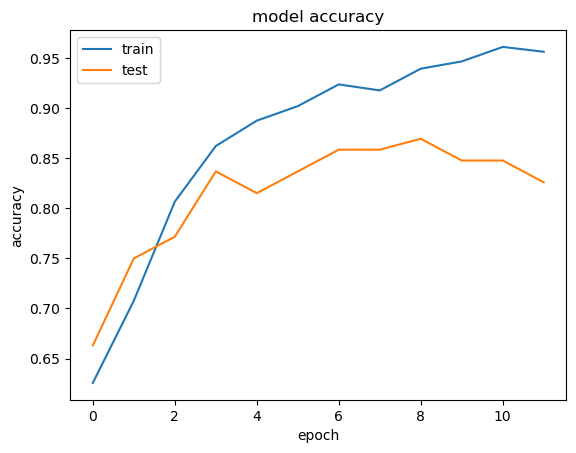

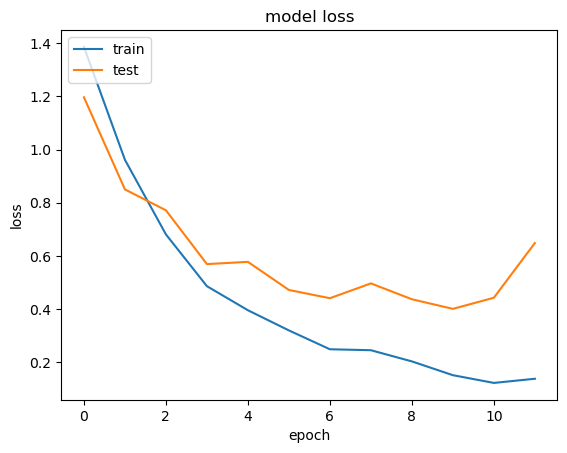

In [31]:
affiche(history)

In [32]:
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=-1)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))

3/3 [==============================] - 0s 8ms/step
Confusion Matrix
[[ 2  0  0  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  6  0]
 [ 0  1  0  4  0  0  0  0]
 [ 0  0  0  0  1  0  2  0]
 [ 0  0  0  0  0  5  1  0]
 [ 0  0  0  0  0  0 61  0]
 [ 0  0  0  0  0  0  2  0]]


In [33]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)

Accuracy:  0.8260869565217391
Precision:  0.694078947368421
Recall:  0.5375000000000001
F1-score:  0.5682042005034706


/home/stagiaire/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Il y a toujours beaucoup de classifications comme 'neutral', mais on trouve à peu près la moitié des cas non 'neutral'. 


## Utilisation de class weight

La forte dissymétrie entre la classe neutral et les autres suggère cependant qu'on pourrait chercher à utiliser le paramètre class_weight. On va chercher à donner plus de poids aux classes sous représentées.

In [34]:
inputs = Input(shape=(48,48,1)) 
tens = Convolution2D(32, kernel_size = (3, 3), activation='relu' )(inputs) 
tens = Convolution2D(64, kernel_size = (3, 3), activation='relu' )(tens) 
tens = MaxPooling2D((3, 3))(tens) 
tens = Flatten()(tens) 
tens = Dense(256, activation='relu')(tens) 
tens = Dropout(0.5)(tens) 
outputs= Dense(8, activation='softmax')(tens) 
model = Model(inputs, outputs) 
# model.summary() 

In [35]:
#Je définis un poids par classe comme la racine de 1/le nombre de cas par classe. J'ai d'abord testé sans racine carrée, 
# mais le poids était trop fort sur les classes les plus rares. 
class_weight={ i : np.sqrt(1/(y_train == i).sum()) for i in range(8)}
print(class_weight)

{0: 0.16012815380508713, 1: 0.1336306209562122, 2: 0.22941573387056177, 3: 0.125, 4: 0.2, 5: 0.11396057645963795, 6: 0.043355498476206, 7: 0.25}


In [36]:
batch_size=20
epochs=20
early=tf.keras.callbacks.EarlyStopping(patience=5)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3,
                                                             decay_steps=10000,decay_rate=0.9)
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr_schedule), metrics=['accuracy'])

tps1 = time.perf_counter()
history =model.fit(x_train, Y_train, batch_size=batch_size, epochs=epochs,
                   verbose=1,validation_data=(x_test, Y_test), callbacks=[early], class_weight=class_weight)
tps2 = time.perf_counter()



print('lr=',lr,'batch_size=',batch_size, 'epochs=',epochs)
print('Temps d apprentissage',tps2 - tps1)

Epoch 1/20
42/42 [==============================] - 3s 55ms/step - loss: 0.1549 - accuracy: 0.6123 - val_loss: 1.4998 - val_accuracy: 0.6630
Epoch 2/20
42/42 [==============================] - 2s 54ms/step - loss: 0.1272 - accuracy: 0.6969 - val_loss: 0.9509 - val_accuracy: 0.7391
Epoch 3/20
42/42 [==============================] - 2s 55ms/step - loss: 0.0894 - accuracy: 0.7886 - val_loss: 0.8507 - val_accuracy: 0.7500
Epoch 4/20
42/42 [==============================] - 2s 54ms/step - loss: 0.0678 - accuracy: 0.8370 - val_loss: 0.8746 - val_accuracy: 0.7826
Epoch 5/20
42/42 [==============================] - 2s 52ms/step - loss: 0.0539 - accuracy: 0.8261 - val_loss: 0.6399 - val_accuracy: 0.8587
Epoch 6/20
42/42 [==============================] - 2s 50ms/step - loss: 0.0454 - accuracy: 0.8780 - val_loss: 0.5416 - val_accuracy: 0.8587
Epoch 7/20
42/42 [==============================] - 2s 49ms/step - loss: 0.0361 - accuracy: 0.8865 - val_loss: 0.6101 - val_accuracy: 0.8478
Epoch 8/20
42

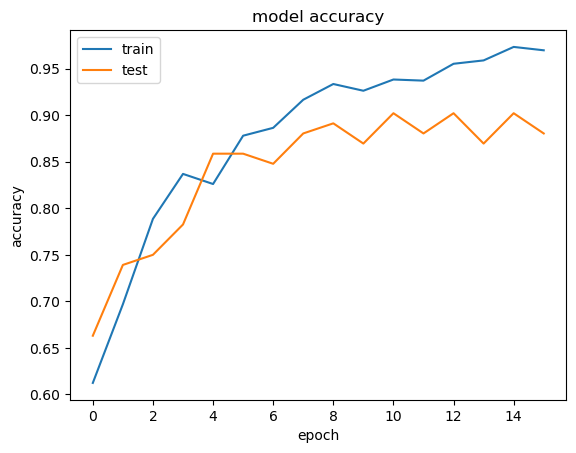

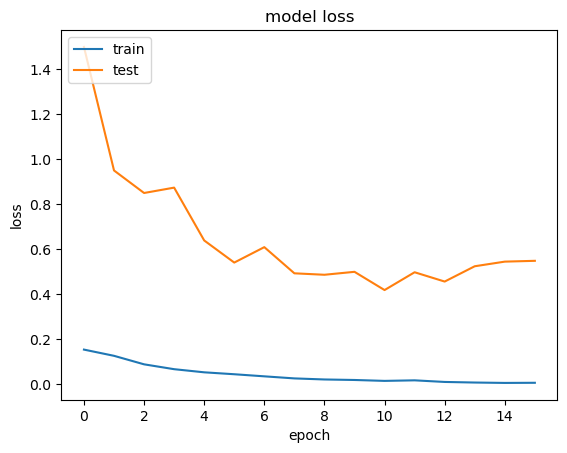

In [37]:
affiche(history)

In [38]:
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=-1)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))

3/3 [==============================] - 0s 8ms/step
Confusion Matrix
[[ 2  0  0  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  0]
 [ 0  0  3  0  0  0  3  0]
 [ 0  0  0  5  0  0  0  0]
 [ 0  0  0  0  1  0  2  0]
 [ 0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0 60  1]
 [ 0  0  0  0  0  0  1  1]]


In [39]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)

Accuracy:  0.8804347826086957
Precision:  0.9196428571428572
Recall:  0.7062841530054644
F1-score:  0.7603371501272265


In [42]:
print(classification_report(y_test, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, 
                      output_dict=False, zero_division='warn'))

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         6
           1       1.00      1.00      1.00         3
           2       1.00      0.50      0.67         6
           3       1.00      1.00      1.00         5
           4       1.00      0.33      0.50         3
           5       1.00      1.00      1.00         6
           6       0.86      0.98      0.92        61
           7       0.50      0.50      0.50         2

    accuracy                           0.88        92
   macro avg       0.92      0.71      0.76        92
weighted avg       0.89      0.88      0.86        92



On a un progrès net sur la précision et le recall, qui étaient à 0.60 et 0.48 précédemment.

# Aperçu des cas mal identifiés

In [44]:
x_err=x_test[y_test != y_pred, :,:,0]
y_err=y_test[y_test != y_pred].reset_index(drop=True)
y_pred_err=y_pred[y_test != y_pred]
x_err.shape, y_err.shape, y_pred_err.shape

((11, 48, 48), (11,), (11,))

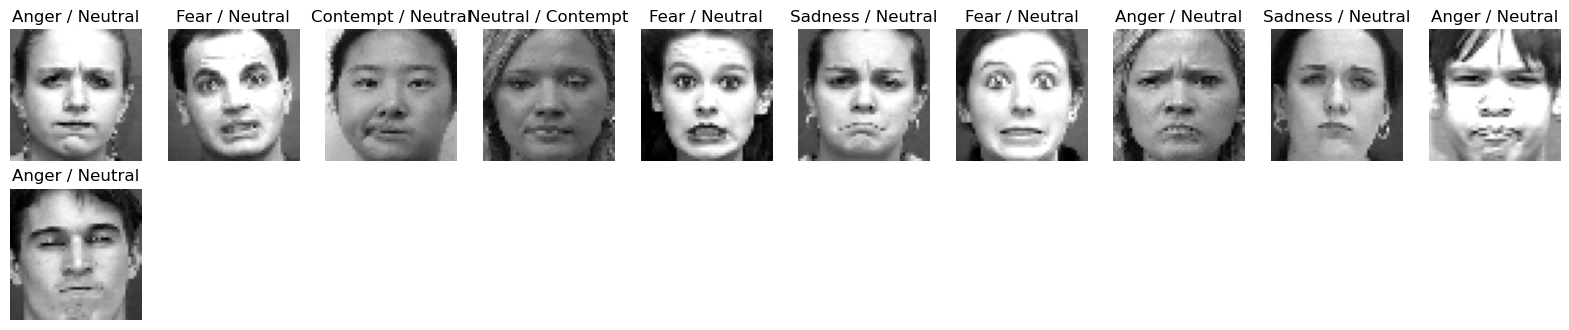

In [45]:
plt.figure(figsize=(20,10))
for i in range(y_err.size) :
    plt.subplot(5,10, i+1)
    plt.imshow( x_err[i], cmap='gray' )
    plt.axis('off')
    plt.title(f"{emotion_list[y_err[i]]} / {emotion_list[y_pred_err[i]]}")
plt.show()

Les images mal classifiées n'ont pas de problème particulier qui explique leur mauvaise classification.

# Utilisation du transfert learning

Dans le tp sur le transfert learning, le modèle inception v3 de transfert learning avait l meilleur f1-score, mais il semble qu'il n'accepte que les images de taille 75x75 au minimum. J'utilise donc resnet50 à la place.
De plus, les différentes fonctions de transfert learning sont sur des images à 3 canaux, donc il faut dupliquer les images pour qu'elles soient sur trois canaux. 

In [51]:
#Importation de la partie inception et mise comme non trainable
from tensorflow.keras.applications import ResNet50
base_model = ResNet50(input_shape = (48,48,3), include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 9s 0us/step


In [52]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 12, 12, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 12, 12, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 12, 12, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_block3_3_bn (BatchNormal  (None, 12, 12, 256)  1024       ['conv2_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 6, 6, 128)   512         ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 6, 6, 128)   0           ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 6, 6, 512)    66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_block3_3_bn (BatchNormal  (None, 6, 6, 512)   2048        ['conv3_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 3, 3, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 3, 3, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 3, 3, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 3, 3, 1024)  4096        ['conv4_block2_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 3, 3, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 3, 3, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 3, 3, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 2, 2, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 2, 2, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 2, 2, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_blo

In [73]:
#Insertion des layers de transfert learning dans le réseau précédent : 
inputs = Input(shape=(48,48,1)) 


tens=Concatenate(axis=3)([inputs,inputs,inputs])
tens=base_model(tens)

tens = Convolution2D(32, kernel_size = (3, 3), activation='relu' )(inputs) 
tens = Convolution2D(64, kernel_size = (3, 3), activation='relu' )(tens) 
tens = MaxPooling2D((3, 3))(tens) 
tens = Flatten()(tens) 
tens = Dense(256, activation='relu')(tens) 
tens = Dropout(0.5)(tens) 
outputs= Dense(8, activation='softmax')(tens) 
model = Model(inputs, outputs) 
# model.summary() 

In [74]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 conv2d_13 (Conv2D)          (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 12544)             0         
                                                                 
 dense_14 (Dense)            (None, 256)               3211520   
                                                           

In [75]:
batch_size=20
epochs=20
early=tf.keras.callbacks.EarlyStopping(patience=5)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3,
                                                             decay_steps=10000,decay_rate=0.9)
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr_schedule), metrics=['accuracy'])

tps1 = time.perf_counter()
history =model.fit(x_train, Y_train, batch_size=batch_size, epochs=epochs,
                   verbose=1,validation_data=(x_test, Y_test), callbacks=[early], class_weight=class_weight)
tps2 = time.perf_counter()



print('lr=',lr,'batch_size=',batch_size, 'epochs=',epochs)
print('Temps d apprentissage',tps2 - tps1)

Epoch 1/20
42/42 [==============================] - 3s 53ms/step - loss: 0.1636 - accuracy: 0.5906 - val_loss: 1.4591 - val_accuracy: 0.6630
Epoch 2/20
42/42 [==============================] - 2s 46ms/step - loss: 0.1459 - accuracy: 0.6449 - val_loss: 1.4121 - val_accuracy: 0.7065
Epoch 3/20
42/42 [==============================] - 2s 45ms/step - loss: 0.1224 - accuracy: 0.7029 - val_loss: 1.3586 - val_accuracy: 0.6413
Epoch 4/20
42/42 [==============================] - 2s 46ms/step - loss: 0.0928 - accuracy: 0.7850 - val_loss: 0.8259 - val_accuracy: 0.7826
Epoch 5/20
42/42 [==============================] - 2s 44ms/step - loss: 0.0732 - accuracy: 0.7790 - val_loss: 0.7262 - val_accuracy: 0.8261
Epoch 6/20
42/42 [==============================] - 2s 45ms/step - loss: 0.0553 - accuracy: 0.8659 - val_loss: 0.7084 - val_accuracy: 0.8478
Epoch 7/20
42/42 [==============================] - 2s 49ms/step - loss: 0.0455 - accuracy: 0.8527 - val_loss: 0.5523 - val_accuracy: 0.8478
Epoch 8/20
42

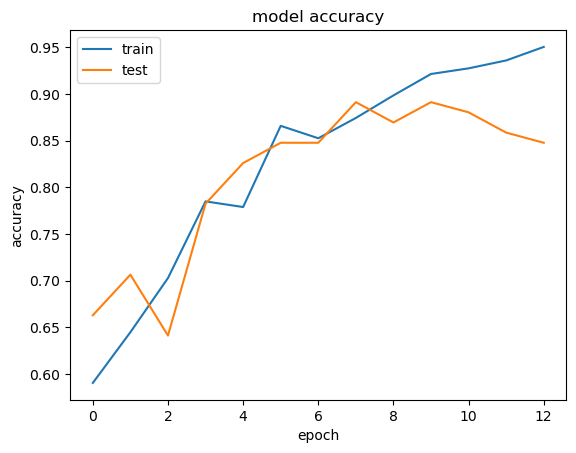

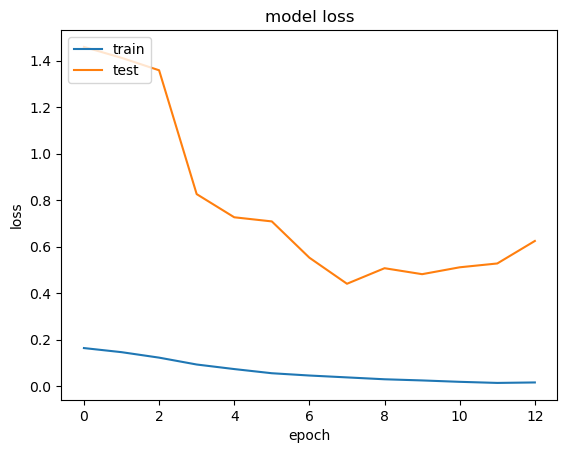

In [76]:
affiche(history)

In [77]:
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=-1)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))

3/3 [==============================] - 0s 10ms/step
Confusion Matrix
[[ 4  0  0  0  0  0  1  1]
 [ 0  3  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  3  1]
 [ 0  0  0  5  0  0  0  0]
 [ 0  0  0  0  1  0  2  0]
 [ 0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0 57  4]
 [ 0  0  0  0  0  0  0  2]]


In [78]:
print(classification_report(y_test, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, 
                      output_dict=False, zero_division='warn'))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       1.00      1.00      1.00         3
           2       0.00      0.00      0.00         6
           3       1.00      1.00      1.00         5
           4       1.00      0.33      0.50         3
           5       0.75      1.00      0.86         6
           6       0.90      0.93      0.92        61
           7       0.25      1.00      0.40         2

    accuracy                           0.85        92
   macro avg       0.74      0.74      0.68        92
weighted avg       0.84      0.85      0.83        92



/home/stagiaire/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stagiaire/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stagiaire/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


On a des résultats comparables avec le transfert learning. De plus, j'ai gardé les couches de la méthode de base bien que ce soit non standard, car cela améliorait de beaucoup les résultats.